In [1]:
!pip install pykan


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Solving the 2D Poisson equation 
$
 \nabla^2 f(x,y) = -2\pi^2 \sin(\pi x) \sin(\pi y) $,

 with boundary condition : $  f(-1,y) = f(1,y) = f(x,-1) = f(x,1) = 0 .$

  The ground truth solution is $ f(x,y) = \sin(\pi x) \sin(\pi y) $.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import *
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.Tanh())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# Problem setup
dim = 2
np_i = 21
np_b = 21
ranges = [-1, 1]

sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])
source_fun = lambda x: -2 * torch.pi**2 * torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])

x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

x_i = torch.rand((np_i**2, 2)) * 2 - 1
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

x_i, x_b = x_i.to(device), x_b.to(device)

# Models
kan_model = KAN(width=[2, 2, 1], grid=5, k=3, seed=1, device=device).to(device)
mlp_model = MLP(2, [32, 32], 1).to(device)

# Training
steps = 100
alpha = 0.01
log = 1
kan_optimizer = torch.optim.LBFGS(kan_model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe")
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

kan_errors, mlp_errors = [], []
kan_times, mlp_times = [], []

def compute_loss(model):
    sol = sol_fun(x_i)
    sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
    sol_D1 = sol_D1_fun(x_i)
    sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
    lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
    source = source_fun(x_i)
    pde_loss = torch.mean((lap - source) ** 2)

    bc_true = sol_fun(x_b)
    bc_pred = model(x_b)
    bc_loss = torch.mean((bc_pred - bc_true) ** 2)

    return alpha * pde_loss + bc_loss, torch.mean((model(x_i) - sol) ** 2)

pbar = tqdm(range(steps), desc='Training', ncols=100)

for step in pbar:
    start_time_kan = time.time()

    def kan_closure():
        kan_optimizer.zero_grad()
        loss, _ = compute_loss(kan_model)
        loss.backward()
        return loss

    kan_optimizer.step(kan_closure)

    kan_times.append(time.time() - start_time_kan)

    start_time_mlp = time.time()

    mlp_optimizer.zero_grad()
    mlp_loss, mlp_l2 = compute_loss(mlp_model)
    mlp_loss.backward()
    mlp_optimizer.step()

    mlp_times.append(time.time() - start_time_mlp)

    _, kan_l2 = compute_loss(kan_model)

    kan_errors.append(kan_l2.item())
    mlp_errors.append(mlp_l2.item())

    pbar.set_description("KAN L2: %.2e | MLP L2: %.2e" % (kan_l2.item(), mlp_l2.item()))

cpu
checkpoint directory created: ./model
saving model version 0.0


KAN L2: 1.95e-05 | MLP L2: 5.11e-03: 100%|████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


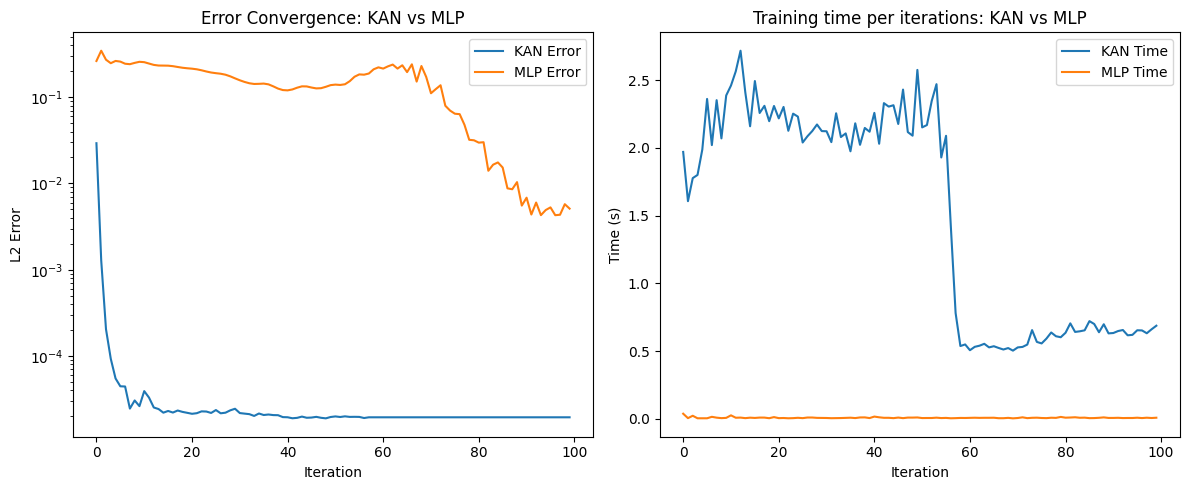

In [3]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(kan_errors, label='KAN Error')
plt.plot(mlp_errors, label='MLP Error')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('L2 Error')
plt.legend()
plt.title('Error Convergence: KAN vs MLP')

plt.subplot(1, 2, 2)
plt.plot(kan_times, label='KAN Time')
plt.plot(mlp_times, label='MLP Time')
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.legend()
plt.title('Training time per iterations: KAN vs MLP')

plt.tight_layout()
plt.show()